In [1]:
import warnings

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_pickle, moving_average
from analyze_tools.monte_carlo import get_colliding_time
#from analyze_tools.utils import field_spectra, DipoleSpectra
import analyze_tools.utils as spectra_utils

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative
import analyze_tools.utils as atu

import gc
import sklearn

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

font = {'size'   : 12}
matplotlib.rc('font', **font)

#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 


Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
d7 =  0.030776244402154505
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
Temperature  119.79126562255514
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.3825301

In [2]:
PATH = 'pickle_jar/cavity-100.0_512_85121110-boltzmann_1_520-c_Lxy1e1s-microz-doublex'
PATH2 = 'pickle_jar/cavity-100.0_512_85121120-boltzmann_1_520-c_Lxy2e1s-microz-doublex'

os.path.isdir(PATH)
os.path.isdir(PATH2)


True

In [8]:
directory_dict = categorizing_pickle(PATH2, '')
for i_, (j, path) in enumerate(directory_dict.items()):
    try:
        with open(path, 'rb') as handle:
            result_dict = pickle.load(handle)
    except:
        print(path)
        continue

    field = result_dict['field']
    
    print(j, np.sum(field.history['energy'][-1]))

17 (894.979882236956+0j)
6 (852.8059554690623+0j)
4 (897.4412504561578+0j)
20 (934.1080660588375+0j)
1 (904.1319151345665+0j)
27 (917.1251354275047+0j)
14 (928.3867432253644+0j)
8 (897.7324947020356+0j)
9 (902.9295551195933+0j)
7 (891.8248143844891+0j)
11 (936.2859246819166+0j)
42 (866.0671232283617+0j)
34 (867.1084248944342+0j)
39 (952.8681836530861+0j)
36 (952.9955873113302+0j)
26 (917.168804086788+0j)
37 (858.6256799667489+0j)
5 (922.239637318282+0j)
15 (920.3399694059958+0j)
41 (929.5981541682511+0j)
3 (953.4561744637857+0j)
12 (932.3111140295315+0j)
21 (914.3829467758045+0j)
45 (nan+nanj)
32 (921.2479160080866+0j)
30 (913.1654213591372+0j)
31 (920.2782670801387+0j)
35 (887.4354669035913+0j)
25 (961.0926144340644+0j)
28 (926.887206692985+0j)
44 (935.2826150825006+0j)
19 (891.0124992831617+0j)
0 (933.7515562505849+0j)
13 (878.445273242849+0j)
43 (918.4068188603457+0j)
40 (894.905073387375+0j)
16 (888.9435147589338+0j)
33 (911.3954248145095+0j)
10 (868.8425333058883+0j)
18 (933.98542

7226

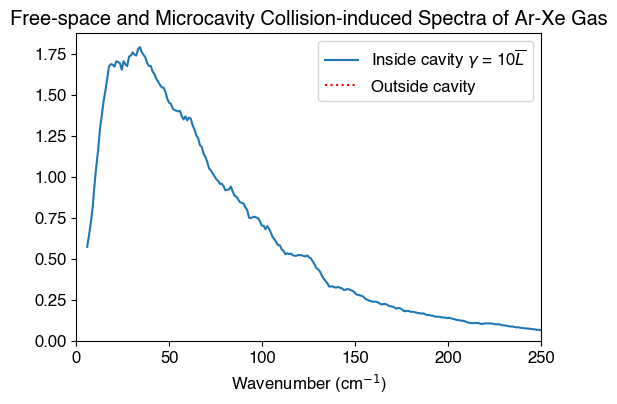

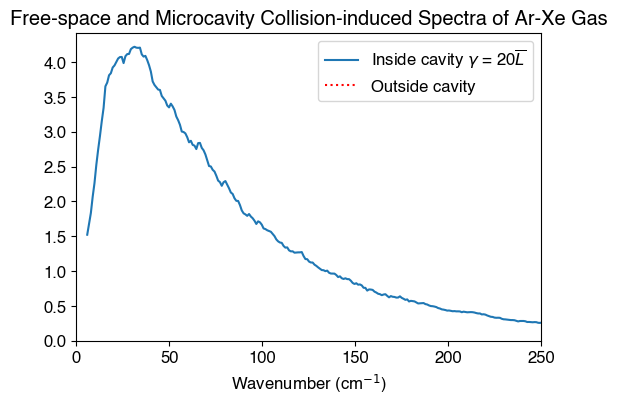

In [5]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""
ROOT2 = 'pickle_jar/'# ROOT # 
temperature_list = ['292.0', '200.0', '100.0']
c_list = ['Lxy1e1', "Lxy2e1"] #
linestyle_list = ["solid", "dashed", "dotted","dashdot"]

seed_cave_512b = [8512110, 8512120]
cavityfield_512b_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
CAVITYFIELD_RESULT_512b_DICT = { # result in cavity field path
    c: cavityfield_512b_path('100.0',seed_cave_512b[i], c)
    for i, c in enumerate(c_list)
}

foo = {'512':CAVITYFIELD_RESULT_512b_DICT}
limit = {'256':40, '512':40, '768':15}
colors = ['r', 'b', 'g']
ct_label = {'Lxy1e1': "10", "Lxy2e1":"20"}

fig1,ax1 = plt.subplots(1, figsize = (6,4))
fig2,ax2 = plt.subplots(1, figsize = (6,4))
fig = [fig1, fig2]
ax = [ax1, ax2]
max_r = {}

original_rad_profile = {}


for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0

        directory_dict_keys = sorted(list(directory_dict.keys()))
        
        for i_, j in enumerate(directory_dict_keys):
            path = directory_dict[j]
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)

            #for calculating the field final temperature
            
            n_pickle += 1
            if n_pickle >= limit[no_collision]: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 10)
        f = f[o > 5]
        o = o[o > 5]
        ax[i].plot(o, f, label = r'Inside cavity $\gamma$ = {}'.format(ct_label[temp]) + r'$\overline{L}$' )
        # to here for rad profile - end of copy
    
        ax[i].set_xlim(0, 250)
        ax[i].set_ylim(bottom = 0)
        
        ax[i].plot(
            [], [], label = "Outside cavity" , 
            linestyle = linestyle_list[2],color=colors[0]
        )
        
        ax[i].set_title(r"Free-space and Microcavity Collision-induced Spectra of Ar-Xe Gas")

        original_omega_profile = o
        original_rad_profile.update({temp : f})
"""
ax[0].plot(
    [], [], label = "Outside cavity, rescale" , 
    linestyle = linestyle_list[2],color=colors[1]
)
"""

#ax[0].set_ylim(0, 1.9)
#ax[1].set_ylim(0, 4.5)
ax[0].set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax[1].set_xlabel(r'Wavenumber (cm$^{-1}$)')

#ax[0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()
ax[1].legend()

gc.collect()

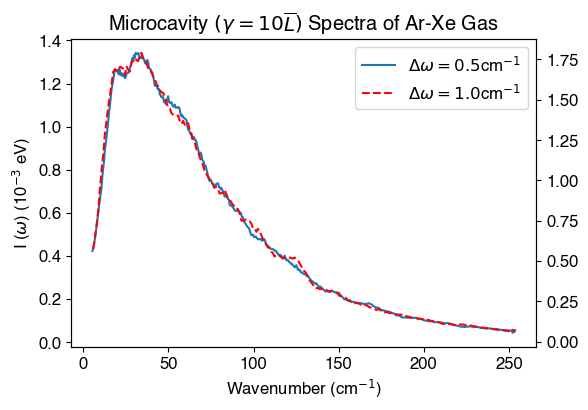

In [6]:
## from copy import deepcopy

fig,ax = plt.subplots(figsize = (6,4))
plt.rcParams.update({'font.size': 12})

directory_dict = categorizing_pickle(PATH, '')

rad_profile = []
n_pickle = 0

directory_dict_keys = sorted(list(directory_dict.keys()))
        
for i_, j in enumerate(directory_dict_keys):
    path = directory_dict[j]
    
    with open(path, 'rb') as handle:
        freefield_result_dict = pickle.load(handle)

    omega_profile, rad_profile1 = spectra_utils.field_spectra(
        freefield_result_dict, 
        convert_function = {
            'energy': red.convert_energy, 
            'wavenumber':red.convert_wavenumber},
        mode = 'std'
    ) 
    rad_profile.append(rad_profile1)

    n_pickle += 1
    if n_pickle >= limit[no_collision]: break

rad_profile = np.mean(rad_profile, axis = 0)

rad_profile *= 1e3 ##############################################################

o, f = moving_average(omega_profile, rad_profile, w = 16)
f = f[o > 5]
o = o[o > 5]
ax.plot(o, f, label = r"$\Delta \omega = 0.5$cm$^{-1}$")

tax = ax.twinx()
tax.plot(original_omega_profile, original_rad_profile['Lxy1e1'], linestyle = '--', c = 'red')

ax.plot([],[], linestyle = '--', c = 'red', label = r"$\Delta \omega = 1.0$cm$^{-1}$")

ax.legend()
    #loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

#ax.set_xlim(0,250)
#ax.set_ylim(0.0, 0.61)
ax.set_ylabel(r"I ($\omega$) (10$^{-3}$ eV)")
ax.set_xlabel(r"Wavenumber (cm$^{-1}$)")

ax.set_title(r"Microcavity $(\gamma = 10\overline{L})$ Spectra of Ar-Xe Gas")

fig.savefig('SIfig/figure/double_wavenumber_10L_spectrum.jpeg',dpi = 600,bbox_inches = 'tight')

In [14]:
freefield_result_dict['field'].k_val

array([1.04719755e-07, 2.09439510e-07, 3.14159265e-07, 4.18879020e-07,
       5.23598776e-07, 6.28318531e-07, 7.33038286e-07, 8.37758041e-07,
       9.42477796e-07, 1.04719755e-06, 1.15191731e-06, 1.25663706e-06,
       1.36135682e-06, 1.46607657e-06, 1.57079633e-06, 1.67551608e-06,
       1.78023584e-06, 1.88495559e-06, 1.98967535e-06, 2.09439510e-06,
       2.19911486e-06, 2.30383461e-06, 2.40855437e-06, 2.51327412e-06,
       2.61799388e-06, 2.72271363e-06, 2.82743339e-06, 2.93215314e-06,
       3.03687290e-06, 3.14159265e-06, 3.24631241e-06, 3.35103216e-06,
       3.45575192e-06, 3.56047167e-06, 3.66519143e-06, 3.76991118e-06,
       3.87463094e-06, 3.97935069e-06, 4.08407045e-06, 4.18879020e-06,
       4.29350996e-06, 4.39822972e-06, 4.50294947e-06, 4.60766923e-06,
       4.71238898e-06, 4.81710874e-06, 4.92182849e-06, 5.02654825e-06,
       5.13126800e-06, 5.23598776e-06, 5.34070751e-06, 5.44542727e-06,
       5.55014702e-06, 5.65486678e-06, 5.75958653e-06, 5.86430629e-06,
      

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


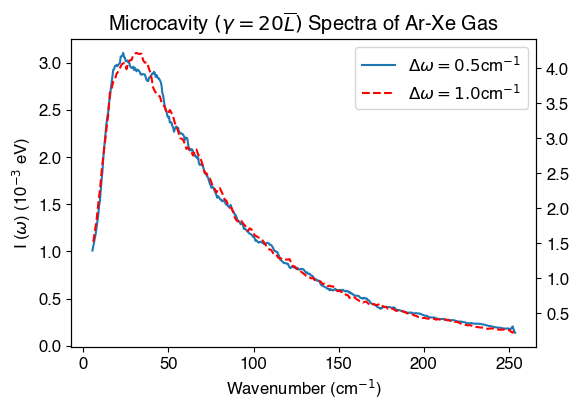

In [9]:
## from copy import deepcopy

fig,ax = plt.subplots(figsize = (6,4))
plt.rcParams.update({'font.size': 12})

directory_dict = categorizing_pickle(PATH2, '')

rad_profile = []

directory_dict_keys = sorted(list(directory_dict.keys()))
for i_, j in enumerate(directory_dict_keys):
    path = directory_dict[j]

    with open(path, 'rb') as handle:
        freefield_result_dict = pickle.load(handle)

    omega_profile, rad_profile1 = spectra_utils.field_spectra(
        freefield_result_dict, 
        convert_function = {
            'energy': red.convert_energy, 
            'wavenumber':red.convert_wavenumber},
        mode = 'std'
    ) 
    rad_profile.append(rad_profile1)

rad_profile = np.mean(rad_profile, axis = 0)

rad_profile *= 1e3 ##############################################################

o, f = moving_average(omega_profile, rad_profile, w = 16)
f = f[o > 5]
o = o[o > 5]
ax.plot(o, f, label = r"$\Delta \omega = 0.5$cm$^{-1}$")

tax = ax.twinx()
tax.plot(original_omega_profile, original_rad_profile['Lxy2e1'], linestyle = '--', c = 'red')

ax.plot([],[], linestyle = '--', c = 'red', label = r"$\Delta \omega = 1.0$cm$^{-1}$")

ax.legend()
    #loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

#ax.set_xlim(0,250)
#ax.set_ylim(0.0, 0.61)
ax.set_ylabel(r"I ($\omega$) (10$^{-3}$ eV)")
ax.set_xlabel(r"Wavenumber (cm$^{-1}$)")

ax.set_title(r"Microcavity $(\gamma = 20\overline{L})$ Spectra of Ar-Xe Gas")

fig.savefig('SIfig/figure/double_wavenumber_20L_spectrum.jpeg',dpi = 600,bbox_inches = 'tight')

In [ ]:
freefield_result_dict['field'].Lz

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# 100K amplitude field           #
##################################

def getall_colliding_time(result_dict_path, limit = None):
    directory_dict = categorizing_pickle(result_dict_path, '')
    
    all_colliding_time = np.array([])
    all_dipole_maxima = np.array([])

    n_pickle = 0
    for i, (j, path) in enumerate(directory_dict.items()):
        if limit and n_pickle >= limit: 
            break

        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue
            
        atoms = result_dict['atoms']
        
        time, no_dipole_maxima = get_colliding_time(atoms, dipole_threshold = 0) #<=====HERE
    
        all_colliding_time = np.hstack([all_colliding_time, time])
        all_dipole_maxima = np.hstack([all_dipole_maxima, no_dipole_maxima])

        del result_dict
        n_pickle += 1
        
    return all_colliding_time, all_dipole_maxima


assoc_limit = 5

bin_dict = {}

#ct0 = getall_colliding_time(FREEFIELD_RESULT_512_DICT['100.0'], limit = limit['512'])
ct0, dm0 = getall_colliding_time('pickle_jar/free-100.0_512_100100-boltzmann_0_0', limit = limit['512'])

#bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
#bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

#ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict2 = {}
dm_dict2 = {}
limit = {'256':40, '512':40, '768':15}
alpha = 0.3

CAVITYFIELD_RESULT_512b_DICT = {
    'Lxy1e1': PATH, 'Lxy2e1': PATH2
}

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']): 
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
    ct, dm = getall_colliding_time(cavityfield_result_dict, limit = limit['512'])

    ct_dict2.update({coup_str : ct})
    dm_dict2.update({coup_str : dm})


In [ ]:
assoc_limit = 5

#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 

font = {'size'   : 15}
matplotlib.rc('font', **font)

fig,ax = plt.subplots(2,2, figsize = (10,8))

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']): 

    ct = ct_dict2[coup_str]

    bin01 = ax[i,0].hist(ct0, np.arange(0,assoc_limit - 0.0001, 0.09999), alpha = alpha, color = 'blue',label = 'Free-space')
    bin1 = ax[i,0].hist(ct, np.arange(0,assoc_limit -0.0001, 0.09999), color = 'red', alpha = alpha,label = 'Microcavity')
    
    bin02 = ax[i,1].hist(ct0, np.arange(assoc_limit-0.0001,214.9999,4.9999), color = 'red', alpha = alpha)
    bin2 = ax[i,1].hist(ct, np.arange(assoc_limit-0.0001,214.9999,4.9999), color = 'red', alpha = alpha)
    
    bin_dict.update({coup_str: (bin1, bin2)})

        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')
    ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(2):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [assoc_limit])
    ax[i,1].set_xlim(assoc_limit,215)
    ax[i,0].set_xlim(0,assoc_limit)
    ax[i,0].set_ylabel('Frequency')

ax[1,0].set_xlabel('Collision time (ps)')
ax[1,1].set_xlabel('Collision time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,0].annotate(r'$\gamma = 10\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate('(b-1)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate(r'$\gamma = 20\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')

ax[0,1].annotate('(a-2)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,1].annotate(r'$\gamma = 10\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate('(b-2)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate(r'$\gamma = 20\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')

ax[0,0].legend(loc = 'center right')

fig.savefig('figure/SI/double_wavenumber_histogram_boltzmann_512.jpeg',dpi=600, bbox_inches = 'tight')


font = {'size'   : 15}
matplotlib.rc('font', **font)